In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider

In [3]:
# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

Using TensorFlow backend.


### 讀入手寫辨識資料及正規化

In [4]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

print("There are %d training data with size %d x %d" %x_train0.shape)
print("There are %d testing  data with size %d x %d" %x_test0.shape)

There are 60000 training data with size 28 x 28
There are 10000 testing  data with size 28 x 28


In [5]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

### Train Autoencoder

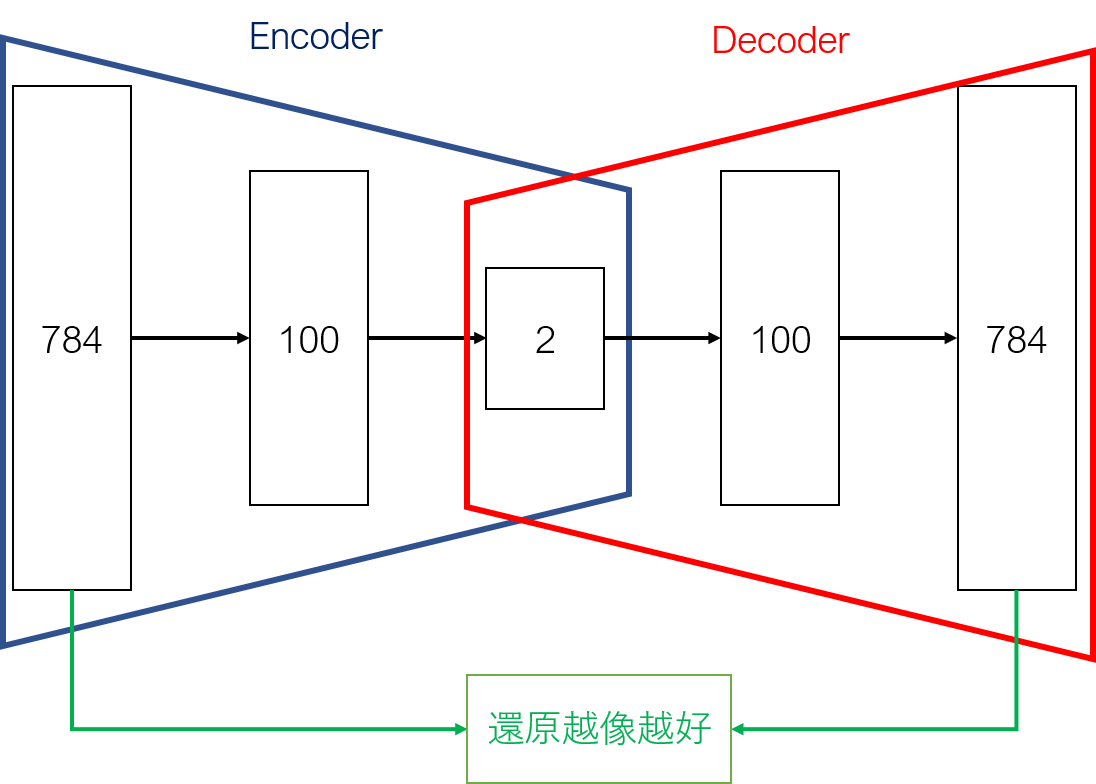

In [6]:
x = Input(shape=(784,))  ##輸入為X(784維)，中間為h(2維)，最後輸出為x_hat(784維)

enc_1 = Dense(100, activation='sigmoid')
enc_2 = Dense(2, activation='sigmoid')

h = enc_2(enc_1(x))

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

x_hat = dec_1(dec_2(h))

In [7]:
autoencoder = Model(x, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 158,186
Trainable params: 158,186
Non-trainable params: 0
_________________________________________________________________


In [8]:
autoencoder.compile(loss='mse', optimizer=Adam())
autoencoder.fit(x_train, x_train, batch_size=1024, epochs=100)

Epoch 1/100
60000/60000 [==============================] - 3s 47us/step - loss: 0.1148
Epoch 2/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0706
Epoch 3/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.0684
Epoch 4/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.0677
Epoch 5/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0673
Epoch 6/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0669
Epoch 7/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0665
Epoch 8/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.0661
Epoch 9/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.0654
Epoch 10/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0647
Epoch 11/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0639
Epoch 12/100
60000/60000 [===============

Epoch 94/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0539
Epoch 95/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0539
Epoch 96/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0539
Epoch 97/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.0538
Epoch 98/100
60000/60000 [==============================] - 1s 23us/step - loss: 0.0538
Epoch 99/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0537
Epoch 100/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0537


### 從 Autoencoder 將 Encoder 和 Decoder 分別定義出來。

In [9]:
Encoder = Model(x, h)
Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [10]:
h_input = Input(shape=(2,))
Decoder = Model(h_input, dec_1(dec_2(h_input)))

Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


不能直接輸入
Decoder = Model(h, x_hat)

因為Decoder 是由 $h$ 開始，所以，我們先準備一個與 $h$ 相同大小的 Input，並餵進 dec_2 及 dec_1 中即可。

### 視覺化

#### 首先，我們隨便抽取一張圖，並透過 Encoder 來算出它的 latent 表示。

In [11]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, Encoder.predict(x_train[idx: idx+1])))

第 53944 圖的 latent 表示為 [[0.7271203  0.49678028]]


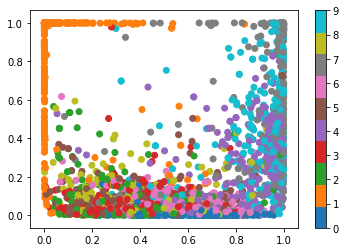

In [12]:
indices = np.random.randint(x_test.shape[0], size=3000)
latents = Encoder.predict(x_test[indices])
plt.scatter(latents[:, 0], latents[:, 1], c=y_test0[indices], cmap="tab10")               
plt.colorbar() #c=上顏色的依據 #cmap=上色方式("tab10"為獨立的10種顏色)
plt.show()

### Variational Autoencoder(VAE)的建立 

$$ \mathbb{R}^n \overset{\mbox{Enc}}{\to} \mathbb{R}^m\times\mathbb{R}^m \overset{\mbox{Sampling}}{\to} \mathbb{R}^m \overset{\mbox{Dec}}{\to} \mathbb{R}^n$$$$ x \overset{\mbox{Enc}}{\mapsto} (\mu, \sigma^2) \overset{\mbox{Sampling}}{\mapsto} h \overset{\mbox{Dec}}{\mapsto} \hat{x} $$

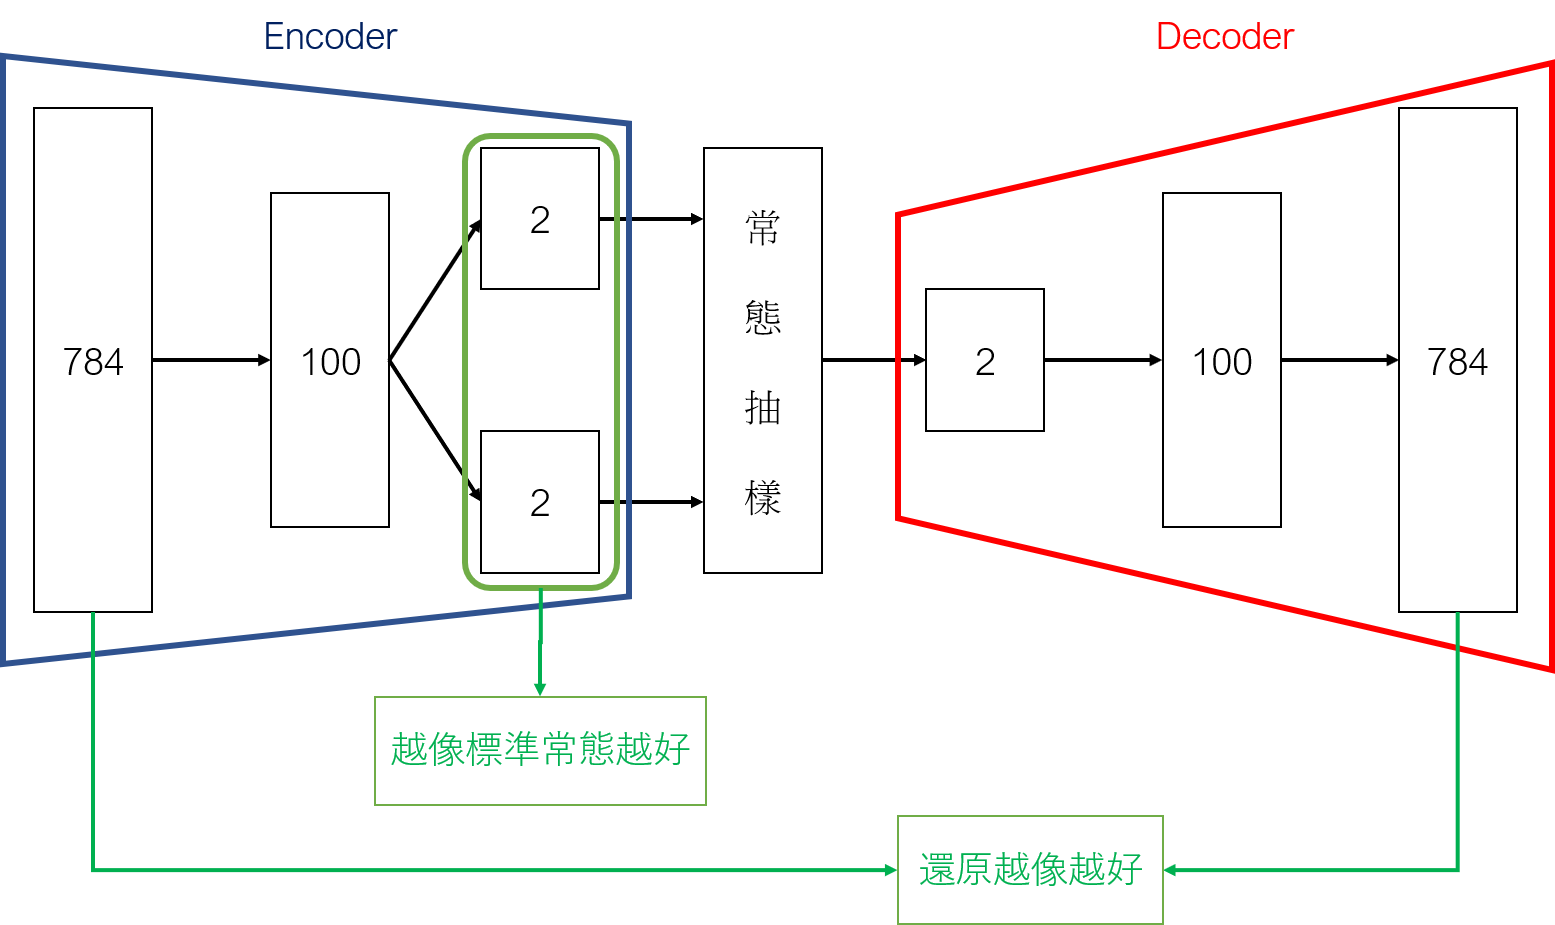

In [13]:
enc_1 = Dense(100, activation='sigmoid')
# enc_2 = Dense(2, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [14]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)       #平均值
z_log_var = enc_log_var(enc_x) #變異數

定義抽樣函數並透過 Lambda 將其轉換成 Keras layer。

透過 $X\sim N(0, 1)\Rightarrow \mu+\sigma X\sim N(\mu, \sigma^2)$ 和 $\sigma = e^{\frac{\log{\sigma^2}}{2}}$，我們透過以下方式定義抽樣函數。

In [15]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1) #透過random_normal做標準常態分配抽樣
    return z_mean + K.exp(z_log_var / 2) * epsilon #符合mean是μ，variance是σ^2的抽樣，所以要平移

In [16]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [17]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [18]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 100)          78500       input_3[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            202         dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            202         dense_5[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

### Loss 函數的建立
$KL(p, q) = \log\dfrac{\sigma_2}{\sigma_1} + \dfrac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\dfrac{1}{2}$

In [19]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

### 模型使用自己訓練的batchsize改為64, epochs改為100

In [20]:
VAE.compile(loss=vae_loss, optimizer=Adam())
VAE.fit(x_train, x_train, batch_size=64, epochs=100)

Epoch 1/100
60000/60000 [==============================] - 5s 79us/step - loss: 205.5023
Epoch 2/100
60000/60000 [==============================] - 4s 72us/step - loss: 183.9879
Epoch 3/100
60000/60000 [==============================] - 4s 72us/step - loss: 181.5272
Epoch 4/100
60000/60000 [==============================] - 4s 72us/step - loss: 180.5336
Epoch 5/100
60000/60000 [==============================] - 4s 74us/step - loss: 179.6459
Epoch 6/100
60000/60000 [==============================] - 4s 72us/step - loss: 178.5581
Epoch 7/100
60000/60000 [==============================] - 4s 73us/step - loss: 177.2573
Epoch 8/100
60000/60000 [==============================] - 4s 72us/step - loss: 175.2292
Epoch 9/100
60000/60000 [==============================] - 4s 73us/step - loss: 172.7484
Epoch 10/100
60000/60000 [==============================] - 4s 72us/step - loss: 170.3826
Epoch 11/100
60000/60000 [==============================] - 4s 72us/step - loss: 168.6464
Epoch 12/100
60000/

60000/60000 [==============================] - 4s 72us/step - loss: 146.5425
Epoch 93/100
60000/60000 [==============================] - 4s 72us/step - loss: 146.4165
Epoch 94/100
60000/60000 [==============================] - 4s 71us/step - loss: 146.4448
Epoch 95/100
60000/60000 [==============================] - 4s 73us/step - loss: 146.4025
Epoch 96/100
60000/60000 [==============================] - 4s 72us/step - loss: 146.3587
Epoch 97/100
60000/60000 [==============================] - 4s 71us/step - loss: 146.2059
Epoch 98/100
60000/60000 [==============================] - 4s 71us/step - loss: 146.1388
Epoch 99/100
60000/60000 [==============================] - 4s 72us/step - loss: 146.2118
Epoch 100/100
60000/60000 [==============================] - 4s 71us/step - loss: 146.1764


### 將VAE的Encoder及Decoder分離出來

In [21]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [22]:
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_9 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


### Encoder 的視覺化呈現

In [23]:
VAE_latents = VAE_Encoder.predict(x_test[indices])

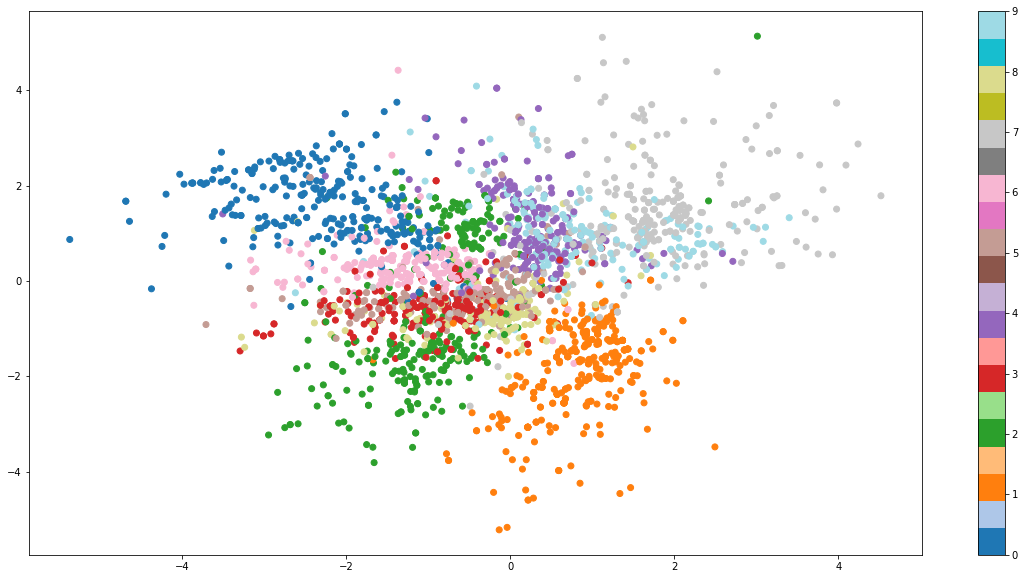

In [24]:
plt.figure(figsize=(20, 10))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()


### Decoder 的視覺化呈現

In [25]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [26]:
n=15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

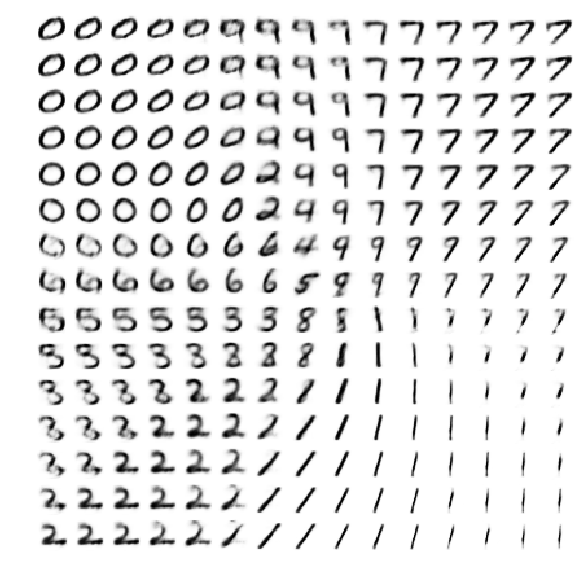

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

### 與 Autoencoder 的 Encoder 進行視覺化比較

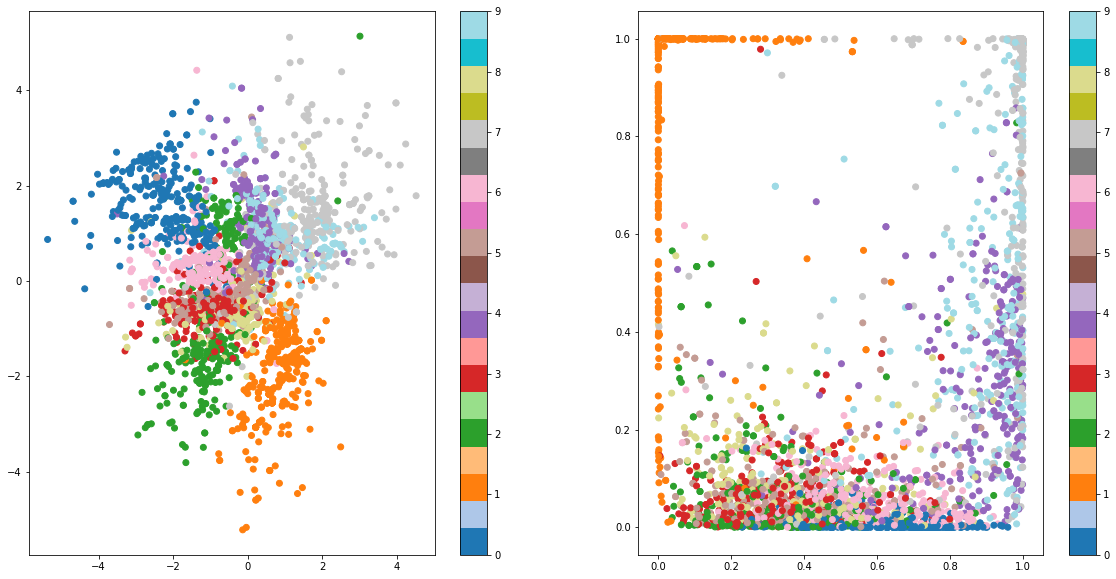

In [28]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(latents[:, 0], latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()


### 動態比較

In [29]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

In [30]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]

In [31]:
interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>